# Merck Challenge
## Sequential Model-based Bayesian optimization

- Vanshita Gupta
- Advaith Rao

## Import packages

In [2]:
# !pip3 install scikit-optimize
%matplotlib inline
import numpy as np
np.random.seed(237)
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from skopt.plots import plot_gaussian_process
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from olympus import Emulator, Dataset
from olympus.models import BayesNeuralNet
from olympus.emulators.emulator import load_emulator

# from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_val_score,train_test_split

from sklearn.metrics import r2_score

## Load our dataset

In [3]:

dataset = Dataset(kind='colors_bob')
data = dataset.data

/Users/arao/Desktop/test_env/lib/python3.8/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## Data Summary

In [4]:
data

,red,orange,yellow,blue,green,difference_to_green
0,0.947644,0.359078,0.850473,0.971819,0.909983,0.138710
1,0.530253,0.999270,0.443194,0.450962,0.849788,0.191651
2,0.148102,0.243153,0.126487,0.769292,0.053864,0.172043
3,0.788710,0.129045,0.141657,0.849663,0.595487,0.043838
4,0.631037,0.172054,0.695530,0.772742,0.066530,0.231567
...,...,...,...,...,...,...
236,0.200784,0.649216,0.820020,0.285841,0.163065,0.424917
237,0.824548,0.655088,0.420614,0.363513,0.417528,0.267281
238,0.712055,0.917876,0.562724,0.949728,0.179134,0.323558
239,0.256854,0.976146,0.998757,0.013524,0.000197,0.540464


In [5]:
data.describe()

,red,orange,yellow,blue,green,difference_to_green
count,241.000000,2.410000e+02,2.410000e+02,241.000000,2.410000e+02,241.000000
mean,0.572001,5.068905e-01,5.163876e-01,0.514785,5.366676e-01,0.209840
std,0.302909,3.231938e-01,2.999546e-01,0.327168,3.040603e-01,0.103676
min,0.000003,2.016962e-09,6.297710e-13,0.000003,4.196967e-08,0.033499
25%,0.352372,2.277921e-01,2.833549e-01,0.211012,2.869038e-01,0.134164
50%,0.598837,4.996985e-01,5.203575e-01,0.474238,5.673906e-01,0.186738
75%,0.850505,8.139260e-01,7.550447e-01,0.802457,8.062321e-01,0.273492
max,0.999948,9.999931e-01,1.000000e+00,1.000000,9.997154e-01,0.543255


## Split data into X and y

In [6]:
# demonstrate data normalization with sklearn

# print(data)
X = data.iloc[:,:-1]
y = data.iloc[:,-1]


In [7]:
n_features = X.shape[1]
n_features


5

## Model Definition and Fitting

In [8]:
model = GaussianProcessRegressor(random_state=0)
model.fit(X,y)

GaussianProcessRegressor(random_state=0)

## Input Space definition

Define the space over which we test the optimum values of parameters for our model

In [9]:



space = [
   Real(min(X['red'].tolist()), max(X['red'].tolist()), name='red'),
   Real(min(X['orange'].tolist()), max(X['orange'].tolist()), name='orange'),
   Real(min(X['yellow'].tolist()), max(X['yellow'].tolist()), name='yellow'),
   Real(min(X['blue'].tolist()), max(X['blue'].tolist()), name='blue'),
   Real(min(X['green'].tolist()), max(X['green'].tolist()), name='green'),
]


## Objective Function Definition

In [12]:


noise_level = 0.1

# maximize
def objective(X):
    # print(X)
#     if isinstance(X, list):
#       X = np.array(X)
    if isinstance(X, list):
       X = [X]
    elif np.shape(X)[0]!=1:
       X = X.reshape(1, -1)
    
   
    preds = model.predict(X)
    # preds = model.predict(X)
    
    # preds = preds.tolist()
    # min_index = preds.index(min(preds))

    # return  preds[min_index]
    return min(preds) + np.random.random_sample() * noise_level


## Run Bayesian optimization with the *Gaussian Process Regressor* surrogate function and *GP_hedge* acquision function

In [13]:
import warnings
warnings.filterwarnings("ignore")

res_gp = gp_minimize(objective, space, n_calls=100, random_state=101)
"Best score=%.4f" % res_gp.fun

'Best score=-0.6899'

## Print the best values of parameters for our model

In [14]:
print("""Best parameters:
- red:%.4f
- orange:%.4f
- yellow:%.4f
- blue:%.4f
- green:%.4f
- Minima of function=%.4f""" % (res_gp.x[0], res_gp.x[1],
res_gp.x[2], res_gp.x[3], res_gp.x[4],
res_gp.fun
))

Best parameters:
- red:0.0000
- orange:0.6326
- yellow:0.0000
- blue:1.0000
- green:0.9997
- Minima of function=-0.6899


## Make the convergence plot

Check the iteration number at which our function converges at the minimum value of f(x)

<AxesSubplot: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

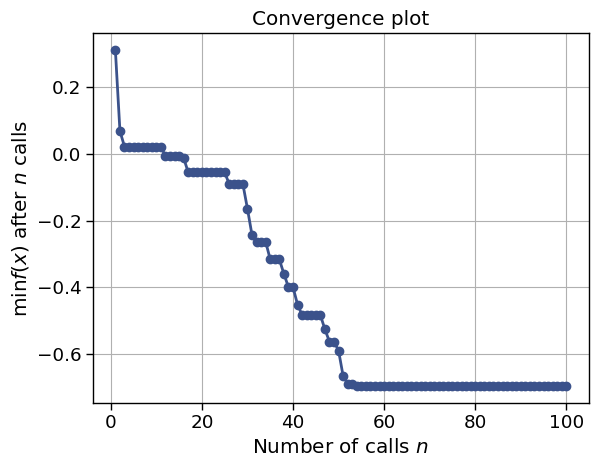

In [ ]:
plot_convergence(res_gp)

<!-- ## Fit our model with the best params -->

## Try different acquision functions

Try to see how different acquision functions affect our convergence at the minima.

In [12]:
res_gp_EI = gp_minimize(objective, space, n_calls=50,acq_func='EI', random_state=101)
res_gp_LCB = gp_minimize(objective, space, n_calls=50,acq_func='LCB', random_state=101)
res_gp_LCB_K5 = gp_minimize(objective, space, n_calls=50,acq_func='LCB', random_state=101,kappa=5)
res_gp_LCB_K10 = gp_minimize(objective, space, n_calls=50,acq_func='LCB', random_state=101,kappa=10)
res_gp_gp_hedge = gp_minimize(objective, space, n_calls=50, random_state=101)

In [15]:
## Make the convergence plot for all the above optimizers

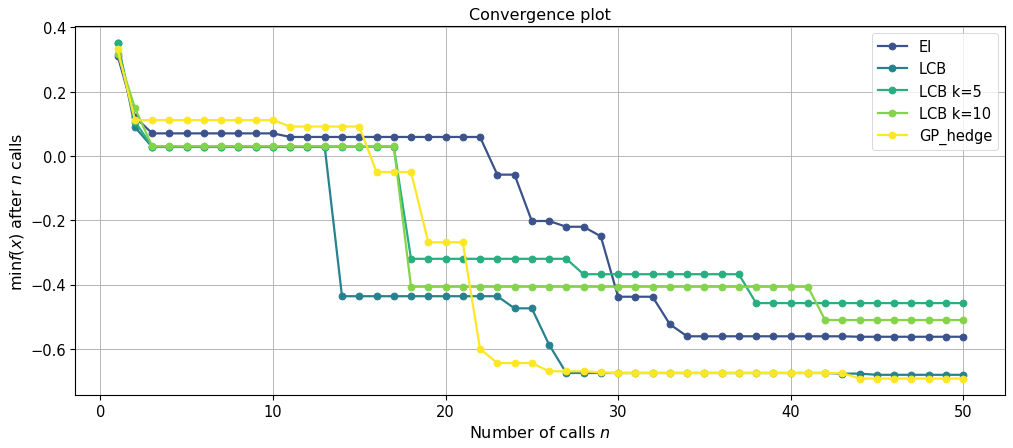

In [13]:
plt.figure(figsize=(15, 6), dpi=80)
plot = plot_convergence(
    ("EI"       , res_gp_EI),
    ("LCB"      , res_gp_LCB),
    ("LCB k=5"  , res_gp_LCB_K5),
    ("LCB k=10" , res_gp_LCB_K10),
    ("GP_hedge" , res_gp_gp_hedge)
    )
#, yscale="log")
plt.show()

**After looking at the Convergence plot we can deduce acquisition function gp_hedge gives the best convergence at minima for our function**

## Try different random states for the best acquision function

Try to see how for the best acquision functions(*gp_hedge* in this case), using different random states affect our convergence at the minima.

In [16]:
res_gp1 = gp_minimize(objective, space, n_calls=50, random_state=101)
res_gp2 = gp_minimize(objective, space, n_calls=50, random_state=201)
res_gp3 = gp_minimize(objective, space, n_calls=50, random_state=301)
res_gp4 = gp_minimize(objective, space, n_calls=50, random_state=401)
res_gp5 = gp_minimize(objective, space, n_calls=50, random_state=501)

## Make the convergence plot for all the above random states

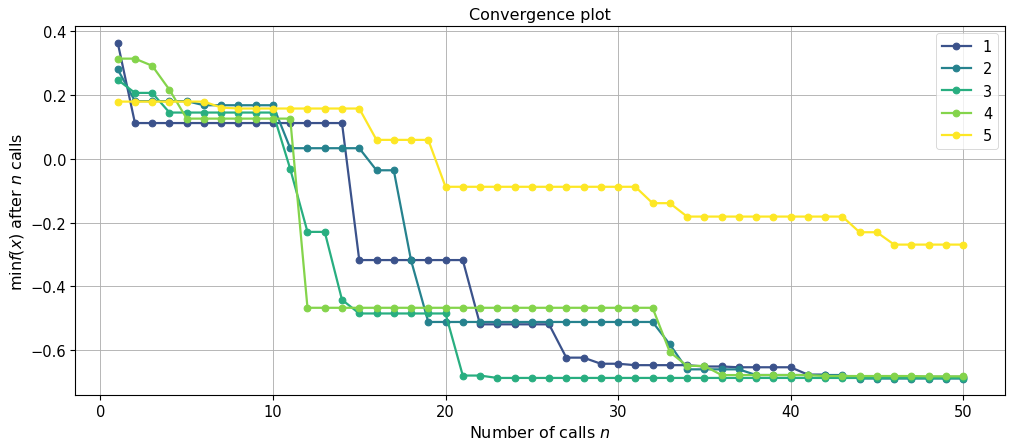

In [17]:
plt.figure(figsize=(15, 6), dpi=80)
plot = plot_convergence(
("1", res_gp1),
("2", res_gp2),
("3", res_gp3),
("4", res_gp4),
("5", res_gp5)
)
#, yscale="log")
plt.show()

## Conclusion

In [18]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=101)

In [19]:
print("""Best parameters:
- red:%.4f
- orange:%.4f
- yellow:%.4f
- blue:%.4f
- green:%.4f
- Minima of function=%.4f""" % (res_gp.x[0], res_gp.x[1],
res_gp.x[2], res_gp.x[3], res_gp.x[4],
res_gp.fun
))

Best parameters:
- red:0.0000
- orange:0.5527
- yellow:0.0000
- blue:1.0000
- green:0.9997
- Minima of function=-0.6934
